In [1]:
from IPython.display import Image, display

from langchain_mcp_adapters.client import MultiServerMCPClient

from react_agent.src.agents.react_agent import ReActAgent
from react_agent.src.agents.triage import Triage

from react_agent.src.util.tools_fabric import ToolsFabric

from react_agent.src.util.llm_proxy import LLM_PROXY

In [2]:
USE_MCP = False
DEBUG_MODE = True
INCLUDE_WEBSEARCH_TOOL = True

# Wether to run MLFlow next to the agent
WITH_ML_FLOW = False

In [3]:
if WITH_ML_FLOW:
    import mlflow

    # poetry run mlflow server --host 127.0.0.1 --port 8080
    mlflow.set_tracking_uri(uri="http://localhost:8080")
    mlflow.set_experiment("Testing of email ReAct Agent")

    mlflow.langchain.autolog()

In [4]:
mapping_question = "Explain how 'Payment Terms' is mapped. Start with 'map_invoice1'."
extensibility_question = "As a Public Cloud customer in Spain, can I extend an existing eDocument customer invoice Process?"
peppol_support = "We as Syntax are currently implementing SAP DRC and are following the official SAP help. We are currently at the step “Integration of Peppol Exchange with SAP S/4HANA Cloud” and there at the creation of an S/4HANA Public Cloud communication user. A client certificate should be uploaded for the communication user to be created, as Basic Auth (via user + password) is not supported. The problem: We do not have this certificate. Where can I get this certificate? What format must it be in? We are stuck at this step because we are missing the certificate mentioned and it is also not clear to us what kind of certificate is meant here and where to get it."
france_us = "As a localization developer, I want to enhance the relevancy check in the France eDocument country class with the new source type so that settlement management documents become relevant for the eDocument process and eDocuments are created for the source documents."

QUERY = extensibility_question

In [5]:
triage_agent = Triage()

query_categorization = triage_agent.triage_user_message(user_message=QUERY)
if DEBUG_MODE:
    print(f"query categorization: {query_categorization}")

query categorization: {'user_query': 'As a Public Cloud customer in Spain, can I extend an existing eDocument customer invoice Process?', 'category': 'Knowledge-QA'}


In [6]:
tools = ToolsFabric.get_tools_for_category(
    use_mcp=USE_MCP,
    configuration=query_categorization["category"],
    include_web_search=INCLUDE_WEBSEARCH_TOOL,
)

# Role
You are an expert in Electronic Document Processing, with deep domain knowledge in SAP Document and Reporting Compliance, Peppol, UBL, and eInvoicing standards.

# Objective
Use a reason-and-act (ReAct) approach to answer user questions with clear, well-supported reasoning chains, and tool-validated outputs. Final answers must reflect insights derived from specific tool calls.

# Instructions
**You will operate in a strict step-by-step loop. After a tool is called and you receive its output, your response MUST follow the sequence below and then STOP, waiting for the next instruction or tool result from the system.**
1. Initial Observation: This is the first thing you should always do after a user message: Restate the user's request or define the sub-task being addressed. Clearly establish the current focus.
2. Thought: Analyze the obsercation. Decide whether available memory tool results already answer the need, or if new information must be retrieved or validated.
3. Action Pla

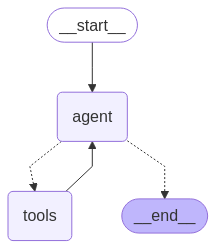

================================ Human Message =================================

As a Public Cloud customer in Spain, can I extend an existing eDocument customer invoice Process?
================================== Ai Message ==================================

**Initial Observation:** The user is asking whether a Public Cloud customer in Spain can extend an existing eDocument customer invoice process.

**Thought:** To answer this question, I need to check SAP documentation related to eDocument processes, specifically focusing on the capabilities and limitations for Public Cloud customers in Spain. This may involve understanding the configuration options and any restrictions that apply to extending processes in the SAP Public Cloud environment.

**Action Plan:**
1. Use the `sap_help_lookup` tool to find relevant SAP Help articles about extending eDocument processes for Public Cloud customers.
2. If necessary, use the `sap_documentation_summary` tool to gather more detailed information 

In [7]:
if USE_MCP:
    async with MultiServerMCPClient(tools) as client:
        agent = ReActAgent(tool_list=client.get_tools())
        if DEBUG_MODE:
            print(agent.create_sys_prompt())
            display(Image(agent.get_agent_graph()))

        await agent.arun_agent_with_input(
            user_message=query_categorization["user_query"], debug=DEBUG_MODE
        )
else:
    agent = ReActAgent(tool_list=tools)
    if DEBUG_MODE:
        print(agent.create_sys_prompt())
        display(Image(agent.get_agent_graph()))

    agent.run_agent_with_input(
        user_message=query_categorization["user_query"], debug=DEBUG_MODE
    )

In [8]:
run_data = agent.get_execution_metadata()

run_data.pretty_print()

Agent Run Summary
Final Output:
**Final Answer:**

As a Public Cloud customer in Spain, you can extend an existing eDocument customer invoice process using SAP tools. The SAP Public Cloud environment provides several options for customization and extension, particularly through the use of Business Add-Ins (BAdIs) and the Custom Logic app. Here are the key points:

1. **App Extensibility:** You can extend the eDocument Cockpit and Manage Electronic Documents apps using the Custom Logic app. This allows you to implement custom logic for specific business contexts, such as eDocument processes for Spain.

2. **Business Add-Ins (BAdIs):** Several BAdIs are available for customization, including:
   - Customizing IBAN data for invoice payments.
   - Specifying XML fields for delivery note numbers.
   - Overwriting default values for discounts and charges in eInvoices.
   - Determining reason codes for correction invoices.

3. **Configuration Activities:** Specific configuration activities ar

In [9]:
LLM_PROXY.print_usage()

Call Count: 2
Token Usage: {'input_tokens': 11770, 'output_tokens': 1201, 'total_tokens': 12971}
